# Stock trading with neural network regression
We want to devise an algorithm for trading the SPDR S&P 500 ETF Trust (SPY) stock in the period of 2000-01-01 to 2010-12-31, using past data only. We're only buying at OPEN and selling at CLOSE values.

First we load the python libraries and load and plot the data:

In [0]:
%reset -f
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.decomposition import PCA
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

print("tensorflow version:", tf.__version__)

tensorflow version: 2.1.0-rc1


In [0]:
train_data = pdr.get_data_yahoo("SPY", start="1900-01-01", end="1999-12-31")
trade_data = pdr.get_data_yahoo("SPY", start="2000-01-01", end="2010-12-31")

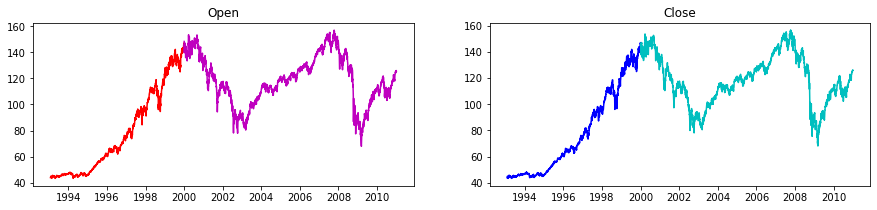

In [0]:
def show_plots(data_a, data_b):
  plt.subplots(figsize=(15, 3))

  plt.subplot(1, 2, 1)
  plt.plot( data_a.loc[:, 'Open'], 'r' )
  plt.plot( data_b.loc[:, 'Open'], 'm' )
  plt.title('Open')

  plt.subplot(1, 2, 2)
  plt.plot( data_a.loc[:, 'Close'], 'b' )
  plt.plot( data_b.loc[:, 'Close'], 'c' )
  plt.title('Close')

  plt.show()

show_plots(train_data, trade_data)

We will be engineering a set of features:
* as input, vectors of certain length (a certain amount of days of past data). For example if our data was [1, 2, 3, 4, 5] and the number of past days we want to consider is 3, our features would be [1, 2, 3], [2, 3, 4], [3, 4, 5].
* as output, the next value in the time series, for each input vector (or some function of the next few values, read below)

We will then use this data to train a neural network to do regression. Neural networks are universal function approximators that can learn the relationship from input and output data on their own.

We could have engineered the features some more. For example, instead of using raw time series values we could've transformed it into a series of returns f(i+1)-f(i), or return rates (f(i+1)-f(i))/f(i) (and these were tried, with no improvement, or even worse performance).

However neural networks with multiple hidden layers have the capacity to learn these features on their own - each layer effectively learns some features of the time series (not necessarily those mentioned above) and passes them to the next layer. Therefore we can just feed the raw time series data as input.

Let's now define some hyperparameters:
*   COST is the (both buying and selling) transation cost
*   COST2, the cost of two transactions (for buying and selling a stock) (this one is calculated from COST)
*   VEC_LEN will be length of our feature vector, essentially the number of past days we will use to predict future value of the stock. There isn't much past data so VEC_LEN has to be small, otherwise our space would be too highly dimensional and we wouldn't get good predictions.
*   FUTURE_LOOKUP_DAYS is the number of days in the future we will look into for time series values. FUTURE_LOOKUP_DAYS=1 just means we are only using the next value (past the input vector). For values larger than 1 we could use the max or average or any function of values from this many days in the future as the value of the stock it could be bought or sold at. Changing this parameter will affect the trading strategy (shorter or longer trades).

In [0]:
VEC_LEN, FUTURE_LOOKUP_DAYS = 4, 3
COST = 0.0025
COST2 = (1+COST)**2-1

Instead of hardcoding FUTURE_LOOKUP_DAYS, we could try to find a suitable value from data, by incrementing the amount of future days until some percent of data (let's say 45-55%) has a profitable change of stock price in that number of days.

Keeping this around 50% will mean our neural network has roughly equal amounts of positive (profitable) and negative data to train on, although in reality on the actual data we want this percent to be high.

In [0]:
def learn_future_days(rate = 0.5):
  open_list = np.array( train_data.loc[:, 'Open'].tolist() )
  close_list = np.array( train_data.loc[:, 'Close'].tolist() )
  dataset = np.concatenate((open_list, close_list))

  n=1
  while True:
    n_day_max = [np.max(dataset[i:i+n]) for i in range(len(dataset)-n+1)]
    r = np.array([ (j-i)/i for i, j in zip(open_list, n_day_max) ]) #return rate
    print( n, np.count_nonzero(r>COST2), len(r) )

    if np.count_nonzero(r>COST2)/len(r) > rate:
      return(n)
    else: n += 1
FUTURE_LOOKUP_DAYS = learn_future_days(0.5)

1 0 1749
2 515 1749
3 786 1749
4 952 1749


Let's now create the actual features:

In [0]:
def get_data(data):
  return np.array( data.loc[:, 'Open'].tolist() ), np.array( data.loc[:, 'Close'].tolist() )

open_list, close_list = get_data(train_data)

def extract_features(dataset, real_output=False):
  # FUTURE_LOOKUP_DAYS = 1 # if we want to avoid using it

  x = np.array([dataset[i:i+VEC_LEN+FUTURE_LOOKUP_DAYS] for i in range(len(dataset)+1-VEC_LEN-FUTURE_LOOKUP_DAYS)])

  if real_output: # output real data, not engineered output feature for prediction
    y = np.array( dataset[VEC_LEN:len(dataset)-FUTURE_LOOKUP_DAYS+1] )
  else:
    y = np.array([ np.average(v[-FUTURE_LOOKUP_DAYS:]) for v in x ]) # play with function here. np.average works better than np.max

  x = np.array([v[:-FUTURE_LOOKUP_DAYS] for v in x])
  

  if False: # this code was just for testing indices, ignore it (it's effectively commented out)
    print(len(x), len(y))

    print('first few items in dataset: ', dataset[:30])
    for i in zip(x[:10], y[:10]): print(i)
    print()
    print('last few items in dataset: ', dataset[-30:])
    for i in zip(x[-10:], y[-10:]): print(i)

  return np.array(x), np.array(y)

xo, yo = extract_features(open_list)
xc, yc = extract_features(close_list)
x, y = np.concatenate((xo, xc)), np.concatenate((yo, yc))

For quick visualization of data we could convert the features (input and output) into rates of return and plot them on a scatter plot.

Oddly there doesn't seem to be any trend. You would think that input vectors which are (roughly) increasing sequences (upper right quadrant) would mostly have profitable outputs and vice versa for decreasing sequences.


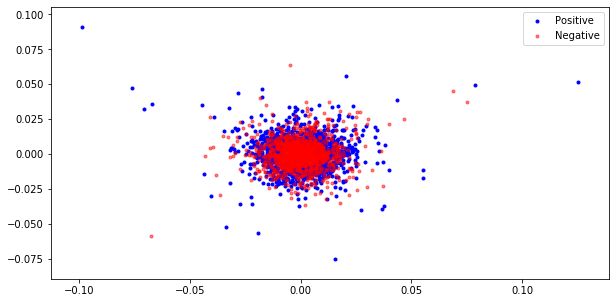

In [0]:
def plot_features(x, y):
  pca = PCA(n_components=2)
  reduced = pca.fit_transform(x)

  plt.figure(figsize=(10, 5))
  plt.scatter(reduced[y==1][:, 0], reduced[y==1][:, 1], marker='.', color='blue', alpha=1, label='Positive')
  plt.scatter(reduced[y==0][:, 0], reduced[y==0][:, 1], marker='.', color='red', alpha=0.5, label='Negative')
  plt.legend()
  plt.show()

def get_categories():
  r = [(j-i)/i for i, j in zip(y[:-1], y[1:])] #rates of return
  categories = []
  for i in r:
    if i<=0: categories.append(0)
    else: categories.append(1)

  return np.array(categories)

def get_feature_rates():
  return np.array([ [(j-i)/i for i, j in zip(v[:-1], v[1:])] for v in x[:-1] ])


plot_features(get_feature_rates(), get_categories())

We now need to split our data into train and test datasets (in say 90:10 proportion). The train dataset will be used to train the parameters of the neural network, while the test dataset is used to test the prediction accuracy. This prevents overfitting on the train dataset and gives better generalization.

In [0]:
mask = (np.random.rand( len(y) ) < 0.9)
train_x, train_y = x[mask], y[mask]
test_x, test_y = x[~mask], y[~mask]

Let's now build and train our neural network model. It will be a simple 4 layer fully connected (dense) network outputting 1 predicted value.

Warning: This cell will take some time to execute. To speed it up reduce the number of epochs.

In [0]:
# this is the training cell that was mentioned further below in another cell
# click (Runtime -> Run after) while this cell is focused to retrain the network 

model = keras.Sequential([
  keras.layers.Dense(VEC_LEN, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])

model.fit(train_x, train_y, epochs=150, batch_size=5, verbose=1)

Train on 3138 samples
Epoch 1/150
3138/3138 [==============================] - 1s 470us/sample - loss: 75.5674 - mae: 2.9604 - mse: 75.5674
Epoch 2/150
3138/3138 [==============================] - 1s 317us/sample - loss: 4.5960 - mae: 1.5034 - mse: 4.5960
Epoch 3/150
3138/3138 [==============================] - 1s 314us/sample - loss: 4.4988 - mae: 1.5066 - mse: 4.4988
Epoch 4/150
3138/3138 [==============================] - 1s 302us/sample - loss: 4.3951 - mae: 1.4866 - mse: 4.3951
Epoch 5/150
3138/3138 [==============================] - 1s 309us/sample - loss: 4.4711 - mae: 1.4756 - mse: 4.4711
Epoch 6/150
3138/3138 [==============================] - 1s 304us/sample - loss: 4.1340 - mae: 1.4277 - mse: 4.1340
Epoch 7/150
3138/3138 [==============================] - 1s 305us/sample - loss: 4.1539 - mae: 1.4131 - mse: 4.1539
Epoch 8/150
3138/3138 [==============================] - 1s 313us/sample - loss: 3.8407 - mae: 1.3753 - mse: 3.8407
Epoch 9/150
3138/3138 [=========================

Evaluate loss on the test set:

In [0]:
test_loss, test_mae, test_mse = model.evaluate(test_x,  test_y, verbose=1)
print("Test loss %f, Test mean absolute error: %f, Test mean squared error: %f." % (test_loss, test_mae, test_mse))

346/346 [==============================] - 0s 289us/sample - loss: 1.7048 - mae: 0.9007 - mse: 1.7048
Test loss 1.704808, Test mean absolute error: 0.900743, Test mean squared error: 1.704808.


The test loss seems to be similar to the loss in the final epoch on the training data, meaning the neural network should generalize well on new data.

Let's now use the trained model to predict the time series on the actual data we will trade on. Surprisingly, it's a pretty good fit.

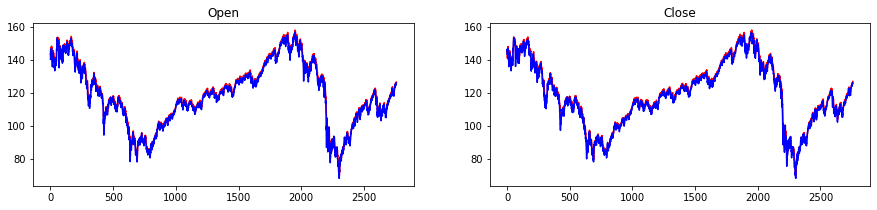

In [0]:
open_data, close_data = get_data(trade_data)
xopen, yopen = extract_features(open_data, real_output=True)
xclose, yclose = extract_features(close_data, real_output=True)

popen = model.predict(xopen, verbose=0) # predicted from open_data
pclose = model.predict(xclose, verbose=0) # predicted from close_data

plt.subplots(figsize=(15, 3))

plt.subplot(1, 2, 1)
plt.plot( popen, 'r', label='Predicted')
plt.plot( yopen, 'b', label='True')
plt.title('Open')

plt.subplot(1, 2, 2)
plt.plot( pclose, 'r', label='Predicted')
plt.plot( yclose, 'b', label='True')
plt.title('Close')

plt.show()


Finally let's trade.

The algorithm is simple:
*   always use all available money
*   buy (at OPEN time) if the prediction for closing time value is above two transation costs
*   sell (at CLOSE time) if we predict the price will fall down and more than FUTURE_LOOKUP_DAYS amount of days has passed since the purchase (since our predictions are for that many days in the future)



In [0]:
class Trading:
  def __init__(self, use_predictions=True):
    self.use_predictions = use_predictions
    self.MONEY = 100000.0
    self.AMOUNT_OF_STOCK = 0
    self.buying = True
    self.counter = 0 # used (or not really used) to train the neural network some more on new data every 20 days
    self.days = 0 # days since last trade
    self.trade()

  def buy(self, price):
    self.MONEY *= (1-COST) #pay fee
    self.AMOUNT_OF_STOCK = self.MONEY // price
    self.MONEY = self.MONEY % price
    print( "Buying %7d stock for $%3.2f per stock. Portfolio value: $%7.2f." % (self.AMOUNT_OF_STOCK, price, self.MONEY + self.AMOUNT_OF_STOCK*price) )
    self.buying = False
    self.days = 0

  def sell(self, price):
    self.MONEY += self.AMOUNT_OF_STOCK * price * (1-COST)
    print( "Selling %6d stock for $%3.2f per stock. Portfolio value: $%7.2f." % (self.AMOUNT_OF_STOCK, price, self.MONEY) )
    self.AMOUNT_OF_STOCK = 0
    self.buying = True
    self.days = 0

  def rate(self, x, y):
    last_item = x[-1]
    return y if last_item==0 else (y-last_item)/last_item

  def trade(self):
    for po, xo, yo, pc, xc, yc in zip(popen, xopen, yopen, pclose, xclose, yclose):
      self.counter += 1

      if not self.use_predictions: pc, po = yc, yo # if the parameter is passed, use actual data, not predictions

      if self.buying:
        if self.rate(xc, pc)>=COST2: self.buy(yo)
        else: self.days += 1
      else:
        if self.rate(xo, po)<0 and self.days>=FUTURE_LOOKUP_DAYS: self.sell(yc)
        else: self.days += 1

      '''
      # we could train the neural network with new data as it's coming in, but it doesn't seem to be doing anything useful
      if self.counter%20 == 19:
        # train the neural network every 20 datapoints, too slow to do it after each new data point
        model.fit(np.concatenate((train_x, xopen[0:self.counter], xclose[0:self.counter])),
                  np.concatenate((train_y, yopen[0:self.counter], yclose[0:self.counter])),
                  epochs=2, batch_size=5, verbose=0)
      '''
    # sell all stocks in the final day
    if not self.buying: self.sell(yclose[-1])

t = Trading()

Buying     710 stock for $140.31 per stock. Portfolio value: $99750.00.
Selling    710 stock for $142.59 per stock. Portfolio value: $101116.58.
Buying     707 stock for $142.56 per stock. Portfolio value: $100863.79.
Selling    707 stock for $141.12 per stock. Portfolio value: $99598.04.
Buying     709 stock for $140.00 per stock. Portfolio value: $99349.05.
Selling    709 stock for $146.19 per stock. Portfolio value: $103476.87.
Buying     682 stock for $151.25 per stock. Portfolio value: $103218.17.
Selling    682 stock for $142.25 per stock. Portfolio value: $96837.64.
Buying     667 stock for $144.62 per stock. Portfolio value: $96595.54.
Selling    667 stock for $145.16 per stock. Portfolio value: $96707.84.
Buying     662 stock for $145.62 per stock. Portfolio value: $96466.07.
Selling    662 stock for $147.12 per stock. Portfolio value: $97215.58.
Buying     661 stock for $146.62 per stock. Portfolio value: $96972.54.
Selling    661 stock for $139.59 per stock. Portfolio value:

The results vary with each training of the neural network.
When np.max was used in engineered features the results range from 20k to 70k USD in the end. When using np.average the results seem to be in the 50k-120k range (run the training cell and all below it a few times).

To insure there isn't a problem with the algorithm itself, we could run it on real data (and not predictions). It always ends up profitable, with around 260k in the end. So the algorithm seems to work.

In [0]:
t2 = Trading(use_predictions=False)

Buying     710 stock for $140.31 per stock. Portfolio value: $99750.00.
Selling    710 stock for $145.81 per stock. Portfolio value: $103396.18.
Buying     709 stock for $145.31 per stock. Portfolio value: $103137.69.
Selling    709 stock for $135.88 per stock. Portfolio value: $96205.67.
Buying     706 stock for $135.81 per stock. Portfolio value: $95965.15.
Selling    706 stock for $142.38 per stock. Portfolio value: $100346.99.
Buying     695 stock for $143.97 per stock. Portfolio value: $100096.12.
Selling    695 stock for $141.08 per stock. Portfolio value: $97842.01.
Buying     719 stock for $135.62 per stock. Portfolio value: $97597.41.
Selling    719 stock for $137.05 per stock. Portfolio value: $98373.39.
Buying     714 stock for $137.25 per stock. Portfolio value: $98127.46.
Selling    714 stock for $149.19 per stock. Portfolio value: $106384.53.
Buying     709 stock for $149.56 per stock. Portfolio value: $106118.57.
Selling    709 stock for $148.69 per stock. Portfolio valu

In the end it's surprising that this approach (sometimes) works. Stock time series data is not i.i.d. since the state of the economy changes with time, the company policies change, the laws change etc.

So it's understanable that a simple Feedforward network (that's what a network with just simple fully connected layers like the one we used is called) is unable to always extract sufficiently complex internal features to model all of that.

Note that we've used the same model for both OPEN and CLOSE time series (to save on training time). In reality there should be a separate model (neural network) for each.

A future approach could be to use multiple and more complex models as well as input data.

Perhaps a network using data from multiple sources (many multiple stocks) could model some general behavior in the market, while a more sophisticated / robust network (perhaps a Convolutional network) could model the specificities of the current stock.

We also don't need to restrict ourselves to just stock data. Text analysis of news pieces could influence the value of the stock.

And, of course, this simple trading algorithm could be replaced by one learned by the computer using (deep) reinforcement learning, where the agent (neural network) trades in a simulated environment (of past stock data) and learns optimal trading moves on its own.